# Transfer Learning with MobileNetV2
Transfer Learning in Neural Network is a technique used in machine learning where knowledge gained from training one model (source domain) is transferred and applied to a **different but related** model (target domain). In neural networs, this involves taking a pre-trained model developed for one task and fine-tuned or using its learned features to solve another related task.

In this project I will be implementing a model using transfer learning with [**MobileNetV2**](https://arxiv.org/pdf/1801.04381.pdf) as the source model. The model will predict an image is an Alpaca image or not Alpaca image.

New things learned:
1. Creat dataset from a directory
2. Preprocess and augment data using the Sequential API
3. Adapt a pretrained model to new data and train a classifier using the functional API MobileNet
4. Fine-tune a classifier's final layer to improve accuracy

<div><div class="alert alert-info">
    <h3>Table of content:</h3>
    <ol>
        <li><a href="#create_dataset">Create Dataset and split into Train and Validation sets</a></li>
        <li><a href="#preprocess_train_set">Preprocess and Augment Train set</a></li>
        <li><a href="#resnet50_function">Implement ResNet (50 Layers)</a></li>
        <li><a href="#configure_learning_process">Configure Learning Process</a></li>
        <li><a href="#using_mobilenet">Using MobileNet50V2 and Transfer Learning</a></li>
        <li><a href="#train_model">Train ResNet50</a></li>
        <li><a href="#save_model">Save the model</a></li>
    </ol>
</div>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

<a id="create_dataset"></a>
## Create Dataset and split into Train and Validation sets
***Keras*** provides `image_data_set_from_directory()` method for generating image dataset from images stored in the disk. We can specify `validation_split=0.2` (or any other value) as the size of the validation set, and create training set using `subset='training'` and validatin set using `subset='validation'`.

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  validation_split=0.2,
                                                  subset='validation',
                                                  seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


### Let's display some images in the train set

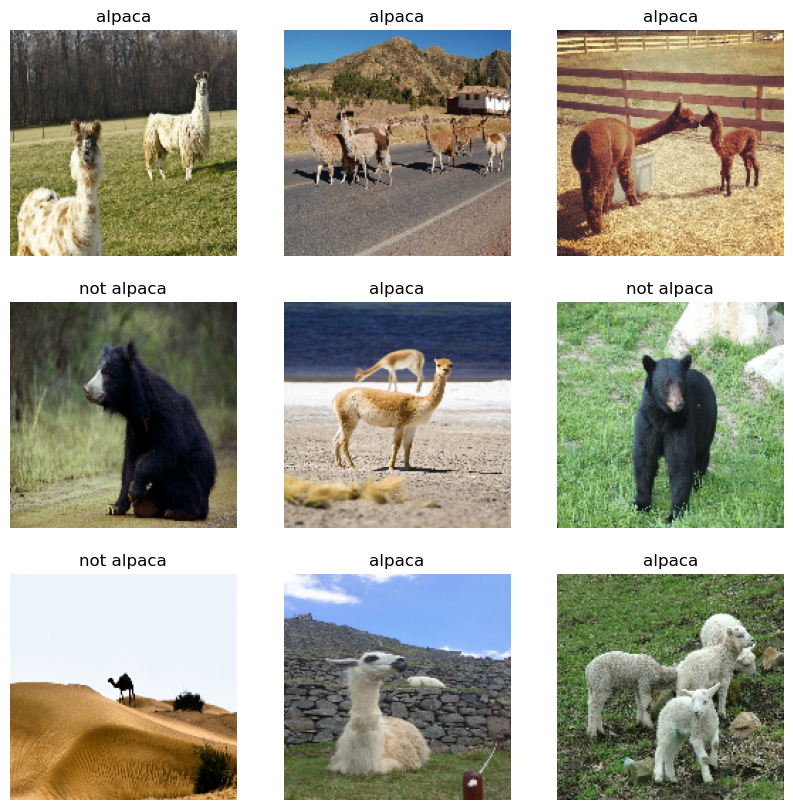

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

<a id="preprocess_train_set"></a>
## Preprocess and Augment Training Data
Data augmentation is one of the ways to increase our train set size and the diversity by applying random (but realistic) transformation, such as image rotation. ***Keras*** provides various methods to perform data augmentation effectively.

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

Implementation of data augmenter

In [12]:
def data_augmenter():
    """
    Create Sequential model composed of 2 layers
    Returns:
    tf.keras.Sequential
    """
    
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    
    return data_augmentation

Now we can use above function to populate our training set

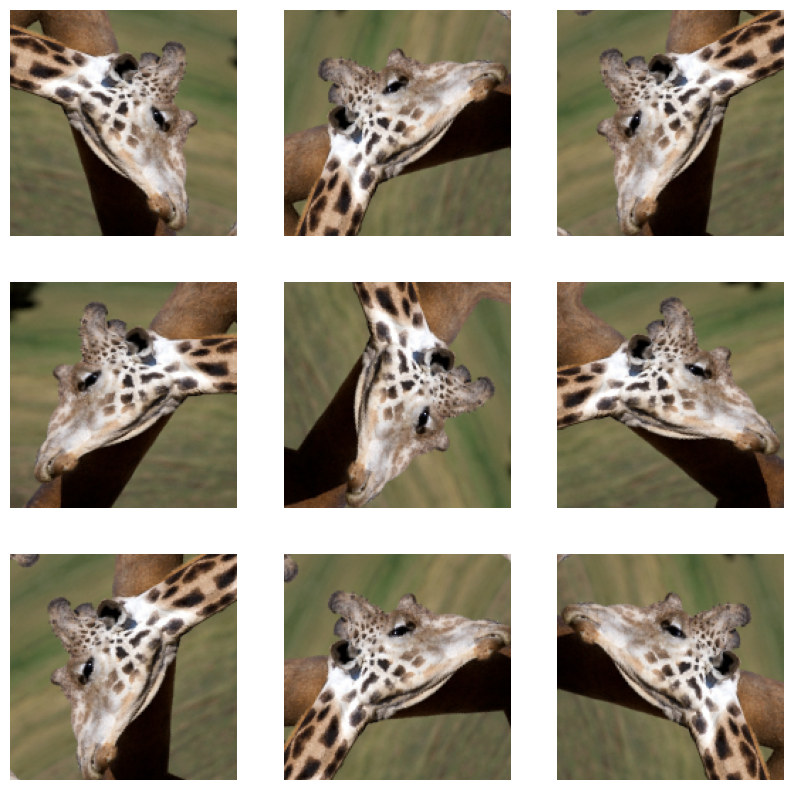

In [13]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [14]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

<a id="using_mobilenet"></a>
## Using MobileNetV2 for Transfer Learning